# Time Series Part II: Differencing, Stationarity, Seasonality & ACF/PACF

In [1]:
# load some useful libraries

import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.tools import diff
import warnings
warnings.filterwarnings("ignore")

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

#### Part I: CO2 emissions

In [2]:
# Load CO2 dataset
df = pd.read_csv('time_series_data/LPI_data.csv')

display(df.head())

,Unnamed: 0,Year,co2,population,gdp_growth,lpi
0,0,1970,14898157000.00000,3695390208,3.98153,100.00000
1,1,1971,15502787000.00000,3770163200,3.11649,99.10027
2,2,1972,16223440000.00000,3844800768,3.16475,97.92988
3,3,1973,17083500000.00000,3920251392,2.97740,96.78284
4,4,1974,17009382000.00000,3995516928,3.15724,95.34543


#### a) Plot the time series.

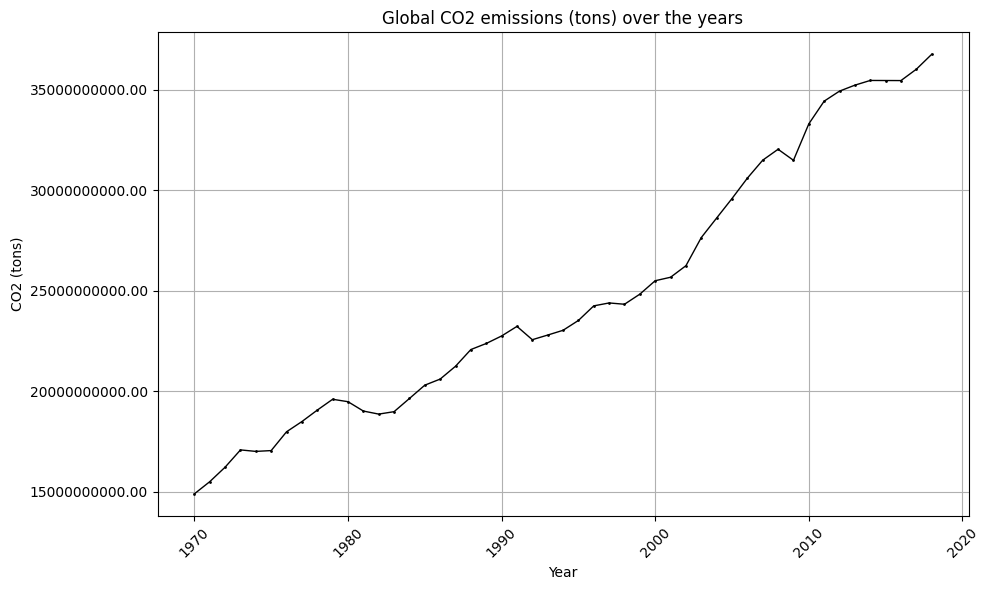

In [3]:
# Convert the 'target_end_date' column to datetime format
df['Year'] = pd.to_datetime(df['Year'].astype(str))

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['co2'], marker='o', linestyle='-', color='black',markersize = 1,linewidth=1)
plt.title('Global CO2 emissions (tons) over the years')
plt.xlabel('Year')
plt.ylabel('CO2 (tons)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### b) Using the ADF function test whether the series is stationary. Remember your null-hypothesis is that there is a unit-root (i.e. it's a random walk or a random walk with drift), and hence a non-stationary process. A p-value close to zero here tells us the process is stationary. 

In [4]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(df['co2'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                 0.80450
p-value                        0.99171
#Lags Used                     0.00000
Number of Observations Used   48.00000
Critical Value (1%)           -3.57459
Critical Value (5%)           -2.92395
Critical Value (10%)          -2.60004
dtype: float64

We have a p-value close to 1 so the process is definitely linear. That's not surprising considering the data almost looks like a straight diagonal.

#### c) Stabilise the series' variance via a monotonic transformation. 

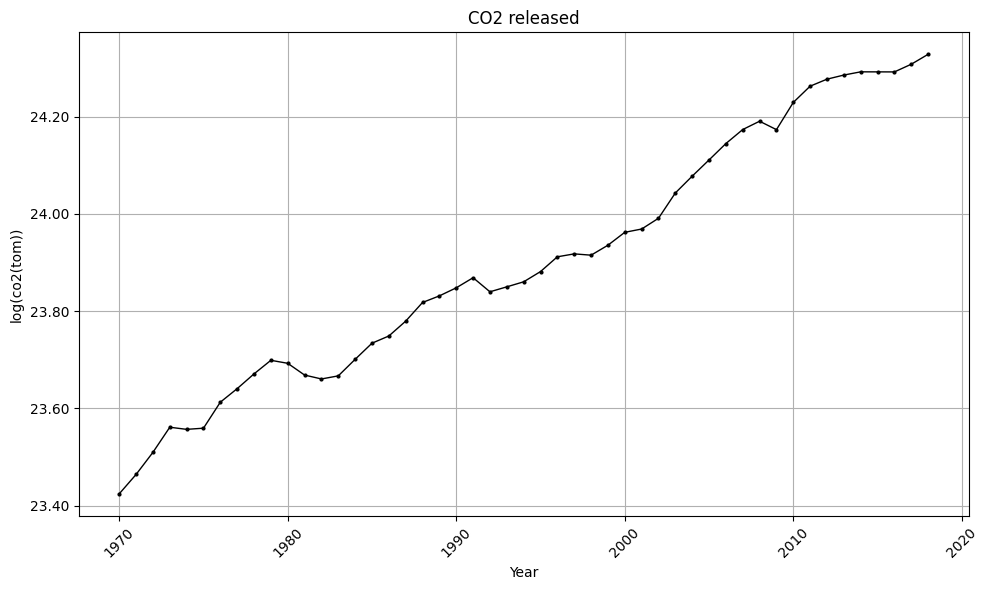

In [5]:
# You can take the log of the series. 
df['log_co2'] = np.log(df['co2'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['log_co2'], marker='o', linestyle='-', color='black',markersize = 2,linewidth=1)
plt.title('CO2 released')
plt.xlabel('Year')
plt.ylabel('log(co2(tom))')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### d) Is the series stationary ? 

In [6]:
adf_result = adfuller(df['log_co2'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                -0.58913
p-value                        0.87342
#Lags Used                     1.00000
Number of Observations Used   47.00000
Critical Value (1%)           -3.57785
Critical Value (5%)           -2.92534
Critical Value (10%)          -2.60077
dtype: float64

#### e) Calculate and plot the first difference of the log USD Bitcoin price. 

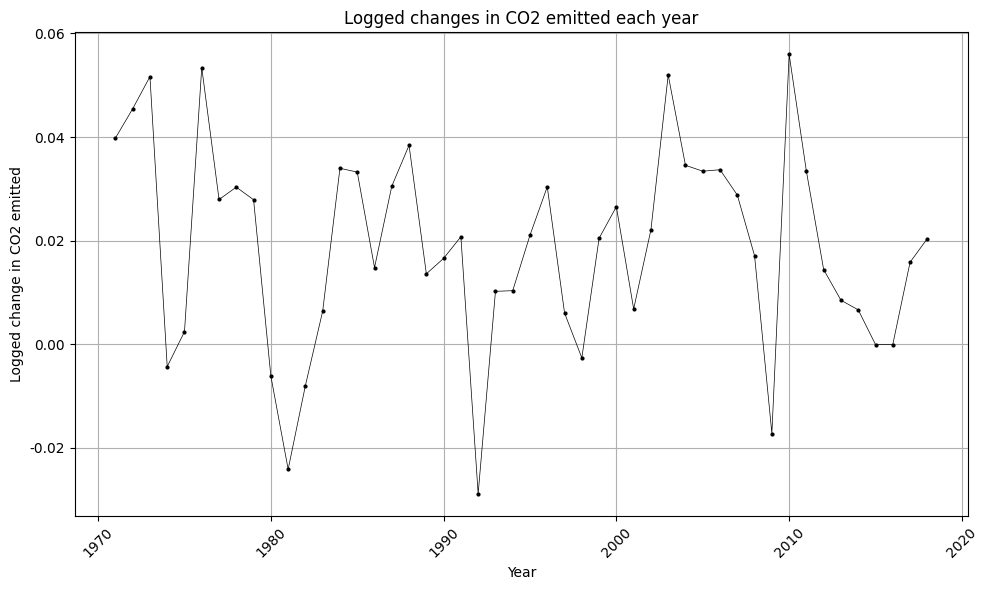

In [7]:
df['log_co2_diff'] = diff(df['log_co2'])

#  Plotting the first difference of the log-transformed series
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['log_co2_diff'], marker='o', linestyle='-', color='black', markersize=2,linewidth=0.5)
plt.title('Logged changes in CO2 emitted each year')
plt.xlabel('Year')
plt.ylabel('Logged change in CO2 emitted')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### f) Is the series stationary now ? 

In [8]:
adf_result = adfuller(df['log_co2_diff'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                -5.12096
p-value                        0.00001
#Lags Used                     0.00000
Number of Observations Used   47.00000
Critical Value (1%)           -3.57785
Critical Value (5%)           -2.92534
Critical Value (10%)          -2.60077
dtype: float64

#### g) Using the ACF and PACF, identify the SARIMA order of this series. 

<Figure size 1200x600 with 0 Axes>

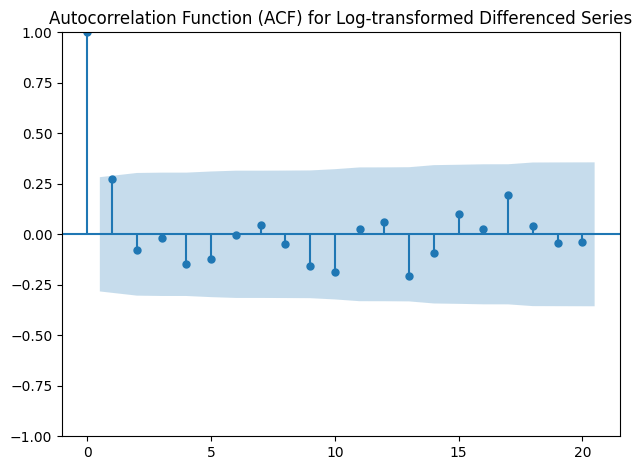

<Figure size 1200x600 with 0 Axes>

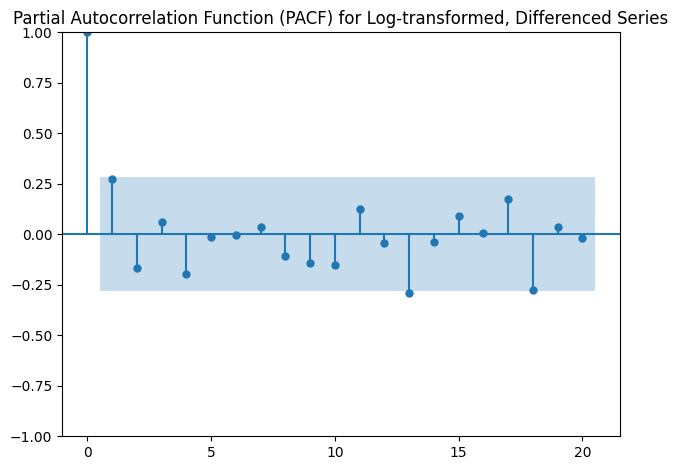

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df['log_co2_diff'].dropna(), lags=20, alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Differenced Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df['log_co2_diff'].dropna(), lags=20, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed, Differenced Series')
plt.tight_layout()

plt.show()

Answer: It's a bit difficult to estimate just from this since a few things are on the edge. The autocorrelation at 1 suggests maybe an autoregression order of 1. It almost looks like there's some seasonality here, but I'm not sure if I'm seeing things...

#### h) Now Use the auto_arima function to estimate an optimal order for the series `on the original scale, before differencing`, and generate a summary of the model. 

In [10]:
from pmdarima import auto_arima
import pandas as pd

# Note: We drop the first NaN value that results from differencing
series = df['co2'].dropna()
series.index = pd.to_datetime(df['Year'])  # Assuming 'series.index' contains date strings


# Use auto_arima to find the optimal SARIMA model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,  # Maximum p and q
                        #m=4,  # Adjust this based on your seasonality (e.g., 12 for monthly data with annual seasonality)
                        #start_P=0, start_Q=0, 
                        #max_P=20, max_Q=20,
                        seasonal=False,  # Enable search for seasonal parameters
                        #D=1,  # Assuming one seasonal differencing. Adjust as needed.
                        test='adf',  # Use ADF test to find optimal 'd'
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2034.545, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2036.076, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2036.481, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2032.587, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2035.521, Time=0.06 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.168 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   49
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1015.294
Date:                Tue, 02 Apr 2024   AIC                           2032.587
Time:                        14:15:51   BIC                           2034.437
Sample:                    01-01-1970   HQIC                          2033.283
                         - 01-01-2018                                       

#### Time Series Model Evaluation: Rolling Forecast Origin

Now that we have fitted our model it is a good time to test its forecasting abilities.

As said before (in the previous workbook), we cannot just apply k-fold cross validation on our time series data: we need a methodology that respects the chronological order of the data. This necessity brings us to the concept of **rolling forecast origin** and **expanding window** approaches, designed specifically for the sequential evaluation of time-series models.

##### Rolling Forecast Origin: Leveraging Temporal Dynamics

Think of time-series cross-validation as a systematic way to "walk forward" through your data. This approach is akin to unfolding the data piece by piece, using each new piece to test the forecasting ability of the model trained on all the preceding pieces.

1. **Data Splitting**: Start by delineating your dataset into training and testing segments. This initial step is more straightforward than in k-fold, focusing on a temporal split rather than a random one.

2. **Model Training**: Train your ARMA model on the designated training data. This process equips the model with the historical context needed to make its first set of forecasts.

3. **Rolling Forecasts**: Deploy the model to predict the immediate next time point in the sequence, then incorporate this actual next point into your training dataset for the subsequent prediction. This step mirrors real-world forecasting scenarios where predictions are continually updated with the latest data.

4. **Performance Evaluation**: Assess the model's forecasting accuracy at each step by comparing the predictions against the actual observations. Metrics like the Mean Squared Error (MSE) serve as quantitative measures of the model's precision.

5. **Iterative Validation**: Repeat the forecast-and-update cycle across the testing dataset. This iterative process provides a cumulative assessment of the model's performance over time, offering insights into its reliability and robustness.

More on rolling origin can be found [here](https://openforecast.org/adam/rollingOrigin.html).


#### i) Using a 'Rolling Origin' type forecast, estimate the expected one-step-ahead generalisation error.

In [11]:
# Extract the order (p, d, q)
order = auto_model.order

# Extract the seasonal order (P, D, Q, m)
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (0, 2, 0)
Seasonal order: (0, 0, 0, 0)


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import trange

# Split the dataset into training and test sets
train_size = int(len(series) * 0.95)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()
predictions = []
confidence_intervals = []

# Rolling forecast origin
for t in trange(len(series_test)):
    # Fit the SARIMA model on the history
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)  # Suppress fitting messages
    
    # Forecast the next point and get the 95% confidence interval
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0])  # Access forecast result correctly
    confidence_intervals.append(conf_int[0])  # Store confidence interval for each forecast
    
    # Correctly add the actual observation from series_test to history for the next loop
    actual_obs = series_test.iloc[t]  # Use .iloc[t] to correctly access the observation
    history = np.append(history, actual_obs)

100%|██████████| 3/3 [00:00<00:00, 70.48it/s]


Test RMSE: 343667316.4568704


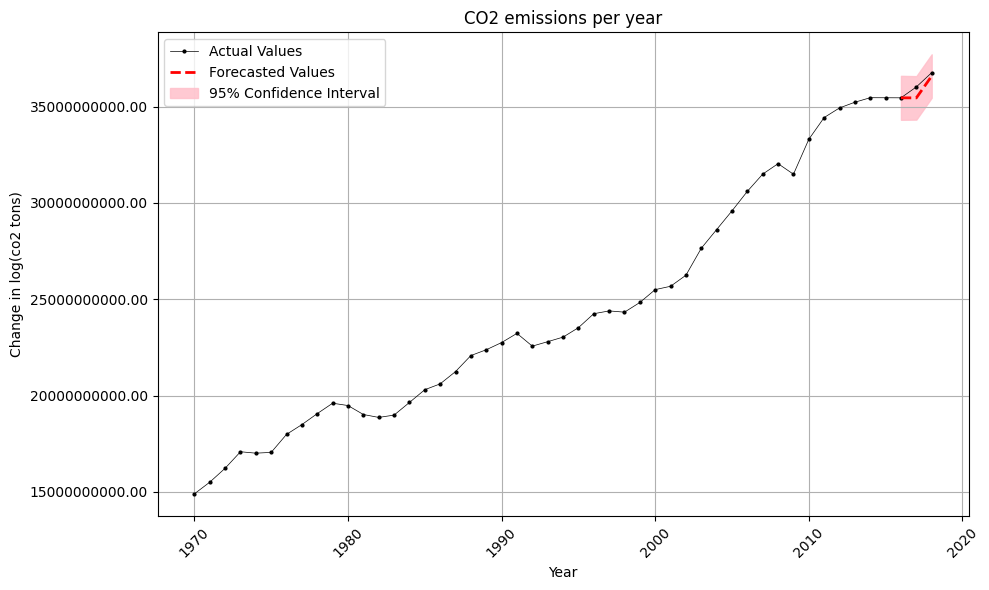

In [13]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

# Plotting the forecast along with the actual series and confidence intervals
plt.figure(figsize=(10, 6))
# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

# Plotting the forecasted values on the test set
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]

# Plotting the confidence interval
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('CO2 emissions per year')
plt.xlabel('Year')
plt.ylabel('Change in log(co2 tons)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Part 2: The Airline Passengers dataset (https://www.kaggle.com/code/sunaysawant/air-passengers-time-series-arima/notebook) -- Series Decomposition & Seasonality.

In [14]:
# Let's try with the Living Planet Index (an index for global biodiversity)
df['lpi'].head()

0   100.00000
1    99.10027
2    97.92988
3    96.78284
4    95.34543
Name: lpi, dtype: float64

#### a) Plot the series

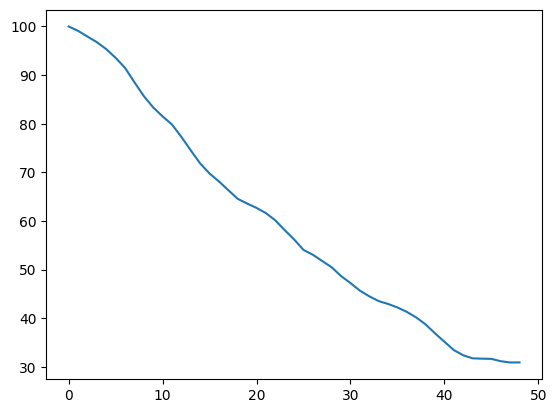

In [15]:
plt.plot(df['lpi'])
plt.show()   

#### b) Check if the time series is stationary 

In [16]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(df['lpi'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                -4.06400
p-value                        0.00111
#Lags Used                    11.00000
Number of Observations Used   37.00000
Critical Value (1%)           -3.62092
Critical Value (5%)           -2.94354
Critical Value (10%)          -2.61040
dtype: float64

#### Decomposing Time Series Data

Take a look at our data again. Can you see a seasonal component? What about a global trend? If we identify these, we can try to remove these components by *differencing*. When we spot a yearly seasonality as in our case, we tackle it by subtracting the data point from the same point one season ago—effectively, each data point minus the one 12 months prior if our data is monthly. This method often helps to smooth out peaks and troughs that occur at the same time each year.

For global trends, which are long-term increases or decreases in the dataset, we apply a similar concept but instead look at the data points one after the other. We subtract each data point from the one before it, which can help to level out any persistent upward or downward drift in the data over time. Through these steps of seasonal and regular differencing, we aim to stabilize the mean of the time series so that the transformed data looks consistent over time, without a trend or seasonality.

#### c) Use `sm.tsa` built-in `seasonal_decompose()` to decompose the series into its constituent parts. 

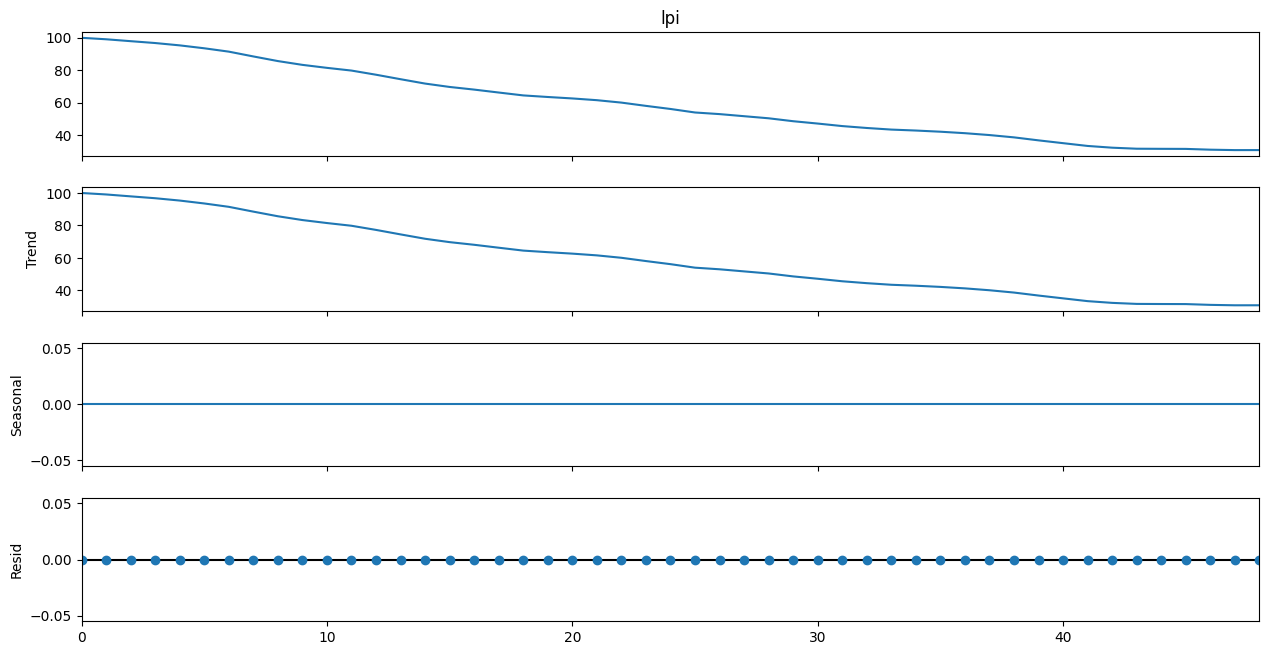

In [17]:
decomposition = sm.tsa.seasonal_decompose(df['lpi'], model='additive', period=1, extrapolate_trend=1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

There's not much to see here since my data has no seasonality... It's why the trend and the data are the same, the seasonal effect is null and thus there are no residuals for it.

#### d) Take a first difference of the series

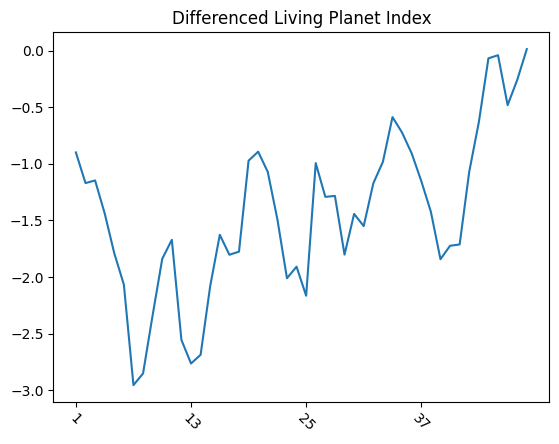

In [18]:
# Differencing
lpi_diff = df['lpi'].diff().dropna()

# Plot the differenced time series
plt.plot(lpi_diff)
plt.title('Differenced Living Planet Index')
plt.xticks(lpi_diff.index[::12], rotation=-45)
plt.show()

#### e) Take a seasonal (let's say 1 year for our unseasonal dataset)

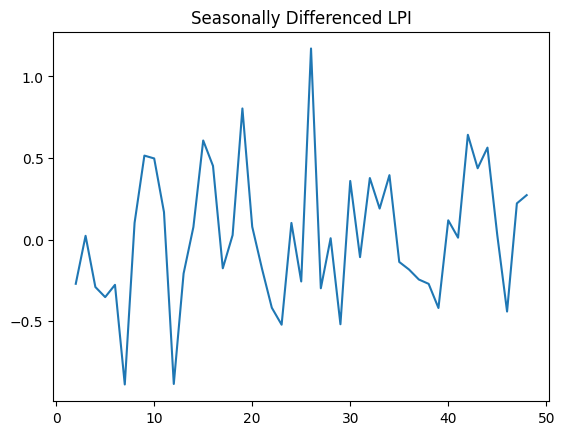

In [19]:
# If you know there is seasonality of a specific period, you can difference by that period
# For example, if there is yearly seasonality, you might do:
seasonal_diff = lpi_diff.diff(1).dropna()

# Plot the seasonally differenced time series
plt.plot(seasonal_diff)
plt.title('Seasonally Differenced LPI')
plt.show()

What I did is the pure equivalent of applying a second order of differencing. Seasonal differencing is just lagged differencing after all and my lag there was 1. There's no seasonality to my data, but it seems to make it stationary enough - to my eyes - if I apply basic differencing to it twice.

#### f) Apply both the differencing and seasonal differencing to the time series

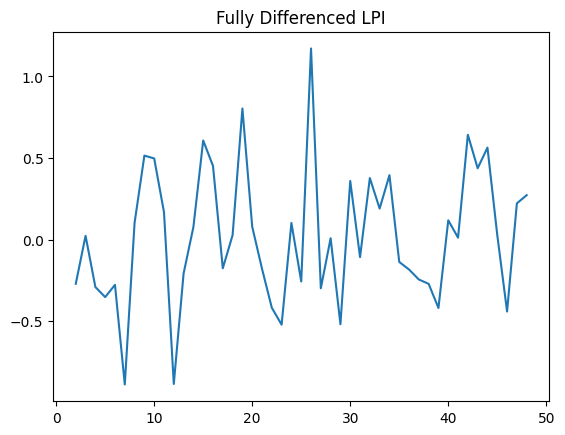

In [20]:
both_diff = lpi_diff.diff(1).dropna()

# Plot the fully differenced time series
plt.plot(both_diff)
plt.title('Fully Differenced LPI')
plt.show()

#### g) Check if the residual series is stationary

In [21]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(both_diff)

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                -5.53981
p-value                        0.00000
#Lags Used                     2.00000
Number of Observations Used   44.00000
Critical Value (1%)           -3.58857
Critical Value (5%)           -2.92989
Critical Value (10%)          -2.60318
dtype: float64

P = 0, so we've made our series non-stationary. We could apply time-series models to it if we wanted, the non-stationary assumption would hold correct.

#### h) Check the ACF and PACF of the residual series -- what model seems to make sense ? 

<Figure size 1200x600 with 0 Axes>

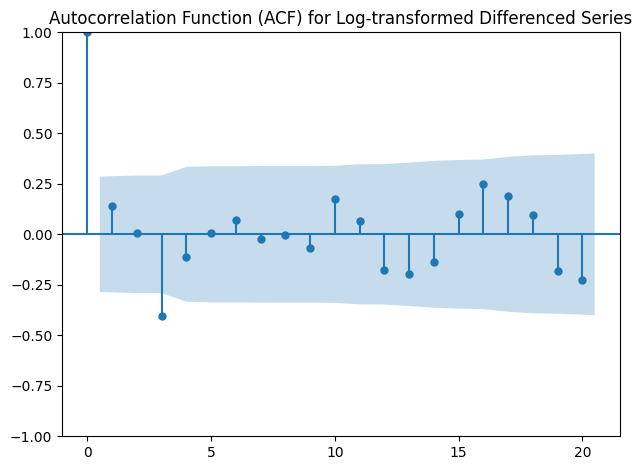

<Figure size 1200x600 with 0 Axes>

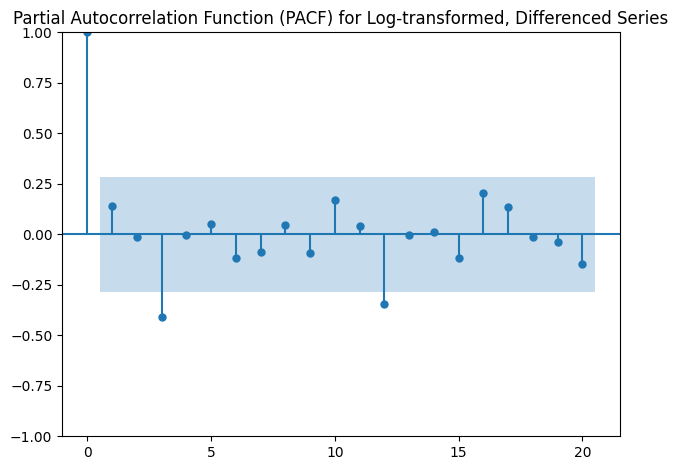

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(both_diff, lags=20, alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Differenced Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(both_diff, lags=20, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed, Differenced Series')
plt.tight_layout()

plt.show()

It's very difficult to discern just by looking at these graphs. They mostly seem to indicate random walks, but again I can't help seeing some kind of hidden sine wave. That's why we have auto_arima.

#### i) Use auto_arima to find an optimal seasonal model -- here we should actually see a non-zero seasonal compoinent, make sure you edit your auto_arima function accordingly. 

In [23]:
# Note: We drop the first NaN value that results from differencing
series = df['lpi']

# Use auto_arima to find the optimal SARIMA model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,  # Maximum p and q
                        m=12,  # Adjust this based on your seasonality (e.g., 12 for monthly data with annual seasonality)
                        start_P=0, start_Q=0, 
                        max_P=20, max_Q=20,
                        seasonal=True,  # Enable search for seasonal parameters
                        D=1,  # Assuming one seasonal differencing. Adjust as needed.
                        test='adf',  # Use ADF test to find optimal 'd'
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=71.684, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=62.553, Time=0.13 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=73.148, Time=0.02 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=64.060, Time=0.16 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=64.064, Time=0.19 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=66.065, Time=0.17 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=61.036, Time=0.04 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=62.645, Time=0.14 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=62.645, Time=0.17 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(2,1,1)[12]             : AIC=64.645, Time=0.13 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=62.610, Time=0.12 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=64.550, Time=

#### l) Finally, perform a the Rolling-origin forecast to predict the one-step-ahead generalisation error, under a scenatio in which we receive updates on our data. 

In [24]:
# Extract the order (p, d, q)
order = auto_model.order

# Extract the seasonal order (P, D, Q, m)
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (0, 2, 0)
Seasonal order: (1, 1, 0, 12)


In [25]:
# Split the dataset into training and test sets
train_size = int(len(series) * 0.8)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()  # Ensure 'history' is a numpy array for model fitting
predictions = []
confidence_intervals = []

# Rolling forecast origin
for t in trange(len(series_test)):
    # Fit the SARIMA model on the history
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)  # Suppress fitting messages
    
    # Forecast the next point and get the 95% confidence interval
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0])  # Access forecast result correctly
    confidence_intervals.append(conf_int[0])  # Store confidence interval for each forecast
    
    # Correctly add the actual observation from series_test to history for the next loop
    actual_obs = series_test.iloc[t]  # Use .iloc[t] to correctly access the observation
    history = np.append(history, actual_obs)

100%|██████████| 10/10 [00:00<00:00, 18.39it/s]


Test RMSE: 0.4038538902795263


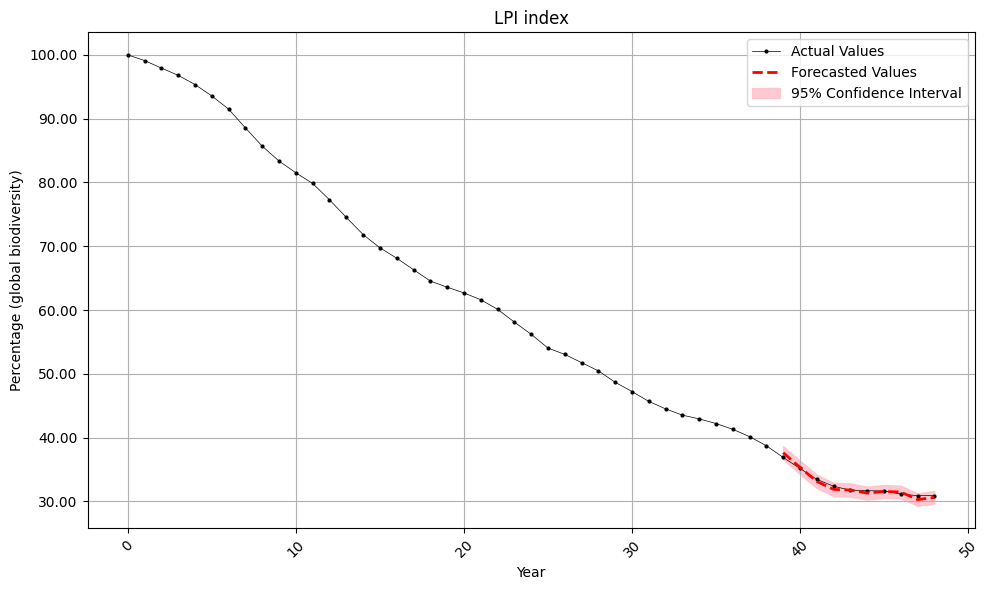

In [26]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

# Plotting the forecast along with the actual series and confidence intervals
plt.figure(figsize=(10, 6))
# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

# Plotting the forecasted values on the test set
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]

# Plotting the confidence interval
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('LPI index')
plt.xlabel('Year')
plt.ylabel('Percentage (global biodiversity)')
plt.grid(True)

# Formatting y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))

# Ensuring dates are nicely formatted and readable
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()